In [2]:
import pandas as pd
import pydeseq2 as deseq2
from dask.dataframe.utils import meta_object_types
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from pydeseq2.dds import DeseqDataSet

In [4]:
counts = pd.read_csv("SL4_counts_renamed.txt", sep="\t")
path = "METADATA_SRA.xlsx"
metadata = pd.read_excel(path)
counts = counts.set_index("Geneid")

# Seleccionar desde la columna 6 en adelante
counts_df = counts.iloc[:, 5:]

# Eliminar genes sin expresión
min_counts = 10  # Umbral mínimo de expresión
min_samples = 3  # Debe estar expresado en al menos 3 muestras
counts_df = counts_df.loc[(counts_df >= min_counts).sum(axis=1) >= min_samples]

# Eliminar genes con conteos totales extremadamente altos (top 1%)
total_counts = counts_df.sum(axis=1)
high_count_threshold = total_counts.quantile(0.99)
counts_df = counts_df.loc[total_counts < high_count_threshold]

# Alinear counts_df con metadata
metadata.index = metadata.iloc[:, 0]
metadata = metadata.drop(metadata.columns[0], axis=1)
counts_df = counts_df.loc[:, metadata.index]

# Eliminar el prefijo "gene:" del índice y transponer
counts_df.index = counts_df.index.str.replace("^gene:", "", regex=True)
counts_df = counts_df.T

In [5]:
# ¿Hay varianza en GC_CONTENT?
print("Varianza GC:", metadata["GC_CONTENT"].var())

# ¿Coinciden STRESS y STUDY perfectamente?
print("\nCrosstab STRESS vs STUDY:")
print(pd.crosstab(metadata["STRESS"], metadata["STUDY"]))

# ¿Cuántos niveles tiene cada variable?
print("\nNiveles de STRESS:", metadata["STRESS"].unique())
print("Niveles de STUDY:", metadata["STUDY"].unique())


Varianza GC: 17.707671957671955

Crosstab STRESS vs STUDY:
STUDY    1  2  3  4  5  6
STRESS                   
Al       0  0  0  0  0  3
CL       0  0  0  1  0  0
D        0  3  0  0  0  0
H        3  0  2  0  0  0
S        3  0  0  0  3  0
S + H    3  0  0  0  0  0
control  3  1  2  1  0  0

Niveles de STRESS: ['S + H' 'H' 'S' 'control' 'D' 'CL' 'Al']
Niveles de STUDY: [1 2 3 4 5 6]


In [6]:
from pydeseq2.dds import DeseqDataSet

dds = DeseqDataSet(
    counts=counts_df,
    metadata=metadata,
    design_factors=["STRESS", "GC_CONTENT"]
)


C:\Users\Trvpe\AppData\Local\Temp\ipykernel_21160\2243711775.py:3: DeprecationWarning: design_factors is deprecated and will soon be removed.Please consider providing a formulaic formula using the design argumentinstead.
  dds = DeseqDataSet(


In [7]:
dds.deseq2()

Fitting size factors...
... done in 0.03 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 2.52 seconds.

Fitting dispersion trend curve...
... done in 0.40 seconds.

Fitting MAP dispersions...
... done in 2.92 seconds.

Fitting LFCs...
... done in 1.77 seconds.

Calculating cook's distance...
... done in 0.04 seconds.

Replacing 0 outlier genes.



In [8]:
# Lista de condiciones únicas excluyendo el control
conditions = metadata["STRESS"].unique()
conditions = [c for c in conditions if c != "control"]

# Diccionario para guardar los resultados
results = {}

# Ejecutar DESeqStats para cada condición vs control
for cond in conditions:
    print(f"Procesando: {cond} vs control")
    
    # Ejecutar DESeqStats con STRESS como contraste
    stat = DeseqStats(dds, contrast=("STRESS", cond, "control"))
    stat.summary() 
    
    # Usar 'results_df' para guardar los resultados
    results[cond] = stat.results_df  


Procesando: S + H vs control


Running Wald tests...
... done in 1.02 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value: STRESS S + H vs control
                     baseMean  log2FoldChange     lfcSE      stat    pvalue  \
Geneid                                                                        
Solyc00g500022.1     3.746014       -2.677725  1.973288 -1.356987  0.174785   
Solyc00g500023.1     7.923382       -4.834982  2.309633 -2.093399  0.036314   
Solyc00g500034.1    14.299603       -7.541594  2.953170 -2.553728  0.010658   
Solyc00g500039.1     4.044053       -1.437800  1.599949 -0.898653  0.368837   
Solyc00g500042.1    20.907036       -8.088404  2.745395 -2.946172  0.003217   
...                       ...             ...       ...       ...       ...   
Solyc12g100310.2   803.887518        0.199874  0.193787  1.031414  0.302346   
Solyc12g100320.2   151.655983        0.368502  0.266080  1.384929  0.166074   
Solyc12g100330.2   443.279154       -1.300265  0.430553 -3.019988  0.002528   
Solyc12g100340.1     2.155722       -0.874669  3.376246 -0.259066  0.

... done in 1.03 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value: STRESS H vs control
                     baseMean  log2FoldChange     lfcSE      stat    pvalue  \
Geneid                                                                        
Solyc00g500022.1     3.746014       -1.581929  1.598695 -0.989512  0.322413   
Solyc00g500023.1     7.923382       -2.279521  1.752613 -1.300641  0.193381   
Solyc00g500034.1    14.299603       -3.218607  1.900090 -1.693923  0.090280   
Solyc00g500039.1     4.044053       -1.312871  1.324247 -0.991409  0.321486   
Solyc00g500042.1    20.907036       -2.537770  1.650798 -1.537299  0.124220   
...                       ...             ...       ...       ...       ...   
Solyc12g100310.2   803.887518        0.235532  0.163603  1.439653  0.149966   
Solyc12g100320.2   151.655983        0.424764  0.223706  1.898755  0.057597   
Solyc12g100330.2   443.279154       -0.636466  0.362602 -1.755272  0.079213   
Solyc12g100340.1     2.155722       -5.720660  3.213399 -1.780252  0.0750

... done in 1.01 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value: STRESS S vs control
                     baseMean  log2FoldChange     lfcSE      stat    pvalue  \
Geneid                                                                        
Solyc00g500022.1     3.746014        0.066998  1.858869  0.036042  0.971249   
Solyc00g500023.1     7.923382       -5.661285  2.380649 -2.378043  0.017405   
Solyc00g500034.1    14.299603       -7.713048  2.858288 -2.698485  0.006966   
Solyc00g500039.1     4.044053       -1.109312  1.572582 -0.705408  0.480556   
Solyc00g500042.1    20.907036       -8.320419  2.645856 -3.144698  0.001663   
...                       ...             ...       ...       ...       ...   
Solyc12g100310.2   803.887518       -0.109833  0.192698 -0.569976  0.568694   
Solyc12g100320.2   151.655983       -0.313932  0.267185 -1.174961  0.240010   
Solyc12g100330.2   443.279154       -0.941794  0.426427 -2.208573  0.027204   
Solyc12g100340.1     2.155722        1.247132  3.326428  0.374916  0.7077

... done in 0.99 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value: STRESS D vs control
                     baseMean  log2FoldChange     lfcSE      stat    pvalue  \
Geneid                                                                        
Solyc00g500022.1     3.746014       -3.096344  2.022665 -1.530824  0.125813   
Solyc00g500023.1     7.923382       -5.099100  2.281561 -2.234917  0.025423   
Solyc00g500034.1    14.299603       -6.909107  2.611895 -2.645247  0.008163   
Solyc00g500039.1     4.044053       -2.935595  1.727748 -1.699088  0.089303   
Solyc00g500042.1    20.907036       -7.512427  2.377684 -3.159556  0.001580   
...                       ...             ...       ...       ...       ...   
Solyc12g100310.2   803.887518        0.764379  0.192362  3.973650  0.000071   
Solyc12g100320.2   151.655983        0.138340  0.265600  0.520859  0.602465   
Solyc12g100330.2   443.279154       -0.387842  0.426941 -0.908422  0.363655   
Solyc12g100340.1     2.155722       -4.804159  3.853628 -1.246659  0.2125

... done in 1.04 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value: STRESS CL vs control
                     baseMean  log2FoldChange     lfcSE      stat    pvalue  \
Geneid                                                                        
Solyc00g500022.1     3.746014        1.280290  2.909479  0.440041  0.659908   
Solyc00g500023.1     7.923382        1.560909  3.167910  0.492725  0.622207   
Solyc00g500034.1    14.299603        2.368899  3.427617  0.691121  0.489489   
Solyc00g500039.1     4.044053        2.031197  2.384143  0.851961  0.394236   
Solyc00g500042.1    20.907036        2.140623  2.989916  0.715948  0.474024   
...                       ...             ...       ...       ...       ...   
Solyc12g100310.2   803.887518        0.459072  0.305158  1.504373  0.132485   
Solyc12g100320.2   151.655983       -1.193332  0.499581 -2.388665  0.016910   
Solyc12g100330.2   443.279154        0.311241  0.666126  0.467241  0.640327   
Solyc12g100340.1     2.155722       -3.007027  6.150826 -0.488882  0.624

... done in 0.99 seconds.



In [9]:
import matplotlib.pyplot as plt
import numpy as np
import os

# Crear carpeta si no existe
os.makedirs("volcano_plots", exist_ok=True)

for cond, df in results.items():
    log2FC = df['log2FoldChange']
    p_adj = df['padj']

    bio_signif = (df['padj'] < 0.05) & (df['log2FoldChange'].abs() > 2)
    stat_signif = (df['padj'] < 0.05) & (df['log2FoldChange'].abs() <= 2)
    not_signif = df['padj'] >= 0.05

    n_red = bio_signif.sum()

    plt.figure(figsize=(10, 8))
    plt.scatter(log2FC[not_signif], -np.log10(p_adj[not_signif]), color='gray', alpha=0.5, label='No significativo')
    plt.scatter(log2FC[stat_signif], -np.log10(p_adj[stat_signif]), color='blue', alpha=0.6, label='Solo estadísticamente significativo')
    plt.scatter(log2FC[bio_signif], -np.log10(p_adj[bio_signif]), color='red', alpha=0.8, label='Significativo (biológico + estadístico)')

    plt.axhline(y=-np.log10(0.05), color='black', linestyle='--', linewidth=1)
    plt.axvline(x=2, color='green', linestyle='--', linewidth=1)
    plt.axvline(x=-2, color='green', linestyle='--', linewidth=1)

    plt.title(f'Volcano Plot: {cond} vs Control\nSignificativos (bio + estad): {n_red}', fontsize=16)
    plt.xlabel('Log2 Fold Change', fontsize=14)
    plt.ylabel('-Log10 (p-adj)', fontsize=14)


    plt.text(
    x=plt.xlim()[0] + 1,
    y=plt.ylim()[1] - 1,
    s=f"N = {n_red} genes",
    fontsize=12,
    color='red',
    horizontalalignment='left',
    bbox=dict(facecolor='white', edgecolor='red', boxstyle='round,pad=0.3')
    )


    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # Guardar figura como PNG
    plot_path = f"volcano_plots/{cond}_vs_control_volcano.png"
    plt.savefig(plot_path, dpi=300)
    print(f"Guardado: {plot_path}")

    plt.close()  # Cierra la figura para no saturar memoria


Guardado: volcano_plots/S + H_vs_control_volcano.png
Guardado: volcano_plots/H_vs_control_volcano.png
Guardado: volcano_plots/S_vs_control_volcano.png
Guardado: volcano_plots/D_vs_control_volcano.png
Guardado: volcano_plots/CL_vs_control_volcano.png
Guardado: volcano_plots/Al_vs_control_volcano.png


In [10]:

# Crear carpeta de salida
output_dir = "genes_significativos_bioestadisticos"
os.makedirs(output_dir, exist_ok=True)

# Umbral de log2FC
logfc_threshold = 2.0

# Iterar sobre cada resultado guardado
for cond, df in results.items():
    # Filtrar por significancia estadística y biológica
    sig = df[(df["padj"] < 0.05) & (df["log2FoldChange"].abs() > logfc_threshold)]

    # Ordenar por padj
    sig_sorted = sig.sort_values("padj")

    # Guardar
    filename = f"{output_dir}/{cond}_vs_control_significativos.csv"
    sig_sorted.to_csv(filename)
    print(f"Guardado: {filename} ({len(sig_sorted)} genes)")

Guardado: genes_significativos_bioestadisticos/S + H_vs_control_significativos.csv (2232 genes)
Guardado: genes_significativos_bioestadisticos/H_vs_control_significativos.csv (676 genes)
Guardado: genes_significativos_bioestadisticos/S_vs_control_significativos.csv (569 genes)
Guardado: genes_significativos_bioestadisticos/D_vs_control_significativos.csv (1471 genes)
Guardado: genes_significativos_bioestadisticos/CL_vs_control_significativos.csv (870 genes)
Guardado: genes_significativos_bioestadisticos/Al_vs_control_significativos.csv (4153 genes)


<Figure size 1000x600 with 0 Axes>

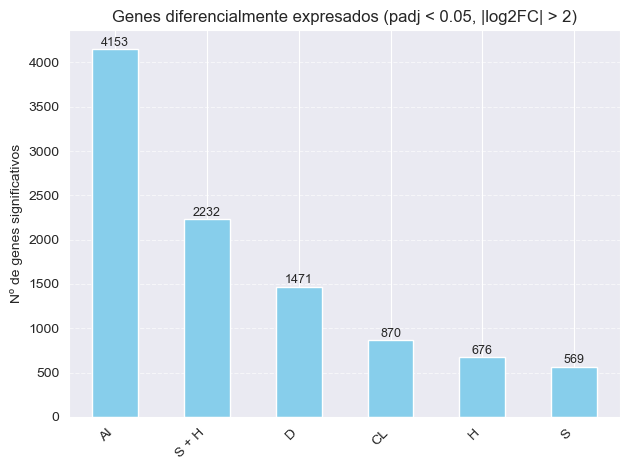

In [11]:
# Crear resumen
logfc_threshold = 2.0
summary_counts = {
    cond: len(df[(df["padj"] < 0.05) & (df["log2FoldChange"].abs() > logfc_threshold)])
    for cond, df in results.items()
}

# Convertir a DataFrame
summary_df = pd.DataFrame.from_dict(summary_counts, orient="index", columns=["Num_genes_significativos"])
summary_df = summary_df.sort_values("Num_genes_significativos", ascending=False)

# Crear carpeta si no existe
os.makedirs("resultados_figuras", exist_ok=True)

# Graficar
plt.figure(figsize=(10, 6))
ax = summary_df.plot(kind="bar", legend=False, color="skyblue")
plt.ylabel("Nº de genes significativos")
plt.title("Genes diferencialmente expresados (padj < 0.05, |log2FC| > 2)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.grid(axis="y", linestyle="--", alpha=0.6)

# Añadir etiquetas en cada barra
for i, val in enumerate(summary_df["Num_genes_significativos"]):
    ax.text(i, val + 1, str(val), ha='center', va='bottom', fontsize=9)

# Guardar imagen
plt.savefig("resultados_figuras/genes_significativos_por_comparacion.png", dpi=300)
plt.show()




In [12]:
from functools import reduce

# Umbral de log2FC
logfc_threshold = 2.0

# Crear diccionario con conjuntos de genes significativos por condición
sets = {
    cond: set(df[(df["padj"] < 0.05) & (df["log2FoldChange"].abs() > logfc_threshold)].index)
    for cond, df in results.items()
}

# Obtener intersección (genes comunes a todas las condiciones)
genes_comunes = reduce(set.intersection, sets.values())

# Mostrar y guardar resultados
print(f"Genes comunes en TODAS las condiciones: {len(genes_comunes)} encontrados.")
genes_comunes

Genes comunes en TODAS las condiciones: 1 encontrados.


{'Solyc02g079930.3'}

In [13]:
# Umbral de log2FC de 1.0
logfc_threshold = 1.0

# Crear diccionario con conjuntos de genes significativos por condición
sets = {
    cond: set(df[(df["padj"] < 0.05) & (df["log2FoldChange"].abs() > logfc_threshold)].index)
    for cond, df in results.items()
}

# Obtener intersección (genes comunes a todas las condiciones)
genes_comunes = reduce(set.intersection, sets.values())

# Mostrar y guardar resultados
print(f"Genes comunes en TODAS las condiciones: {len(genes_comunes)} encontrados.")
genes_comunes

Genes comunes en TODAS las condiciones: 7 encontrados.


{'Solyc02g066930.3',
 'Solyc02g079930.3',
 'Solyc04g079760.4',
 'Solyc06g011350.3',
 'Solyc07g052700.3',
 'Solyc08g079200.1',
 'Solyc11g066100.2'}

In [14]:
from collections import Counter

# Umbral de log2FC
logfc_threshold = 2.0

# Crear diccionario con conjuntos de genes por condición
sets = {
    cond: set(df[(df["padj"] < 0.05) & (df["log2FoldChange"].abs() > logfc_threshold)].index)
    for cond, df in results.items()
}

# Contar cuántas veces aparece cada gen
all_genes = [gene for s in sets.values() for gene in s]
gene_counts = Counter(all_genes)

# Umbral minimo de condiciones
min_conditions = 2

# Filtrar genes que aparecen en al menos 'min_conditions'
genes_recurrentes = [gene for gene, count in gene_counts.items() if count >= min_conditions]

print(f"Número de genes presentes en al menos {min_conditions} condiciones: {len(genes_recurrentes)}")

# Guardar en CSV
os.makedirs("resultados_figuras", exist_ok=True)
pd.Series(sorted(genes_recurrentes)).to_csv(
    f"resultados_figuras/genes_en_al_menos_{min_conditions}_condiciones.csv", index=False
)


Número de genes presentes en al menos 2 condiciones: 2161


In [59]:
import pandas as pd

# Tu lista sin versiones
genes_solyc = [g.split('.')[0] for g in genes_recurrentes]

# Leer archivo GFF completo
gff_path = "ITAG4.0_gene_models.gff"
with open(gff_path, "r") as file:
    lines = [line.strip() for line in file if not line.startswith("#")]

# Diccionarios para almacenar datos
gene_data = {}
note_data = {}

for line in lines:
    cols = line.split("\t")
    if len(cols) < 9:
        continue

    feature = cols[2]
    attrs = dict(item.split("=", 1) for item in cols[8].split(";") if "=" in item)

    # Línea tipo gene: extraer posición
    if feature == "gene":
        gene_id = attrs.get("ID", "").replace("gene:", "").split(".")[0]
        if gene_id in genes_solyc:
            gene_data[gene_id] = {
                "GeneID": gene_id,
                "Chromosome": cols[0],
                "Start": cols[3],
                "End": cols[4],
                "Strand": cols[6],
                "Name": attrs.get("Name", "")
            }

    # Línea tipo mRNA: extraer Note
    elif feature == "mRNA":
        parent_id = attrs.get("Parent", "").replace("gene:", "").split(".")[0]
        if parent_id in genes_solyc:
            note_data[parent_id] = attrs.get("Note", "")

# Unir gene + note
for gene_id in gene_data:
    gene_data[gene_id]["Note"] = note_data.get(gene_id, "")

# Crear DataFrame
df = pd.DataFrame(gene_data.values())
df = df.sort_values("GeneID")
df.to_csv("resultados_figuras/anotaciones_genes_manual.csv", index=False)

print(f"{len(df)} anotaciones guardadas.")
print(df.head())


29 anotaciones guardadas.
           GeneID Chromosome     Start       End Strand              Name  \
0  Solyc01g057000  SL4.0ch01  51153163  51155590      +  Solyc01g057000.3   
1  Solyc01g060200  SL4.0ch01  62977663  62983750      -  Solyc01g060200.3   
3  Solyc01g102960  SL4.0ch01  83883949  83884828      +  Solyc01g102960.3   
4  Solyc01g103920  SL4.0ch01  84715169  84715923      -  Solyc01g103920.3   
2  Solyc01g150149  SL4.0ch01  79787120  79788237      -  Solyc01g150149.1   

                                                Note  
0                           Universal stress protein  
1  3'-5' exonuclease domain (AHRD V3.3 *** A0A200...  
3  22.0 kDa class IV heat shock protein (AHRD V3....  
4            Ferredoxin (AHRD V3.3 *** K4B1W7_SOLLC)  
2                                    Unknown protein  
